In [4]:

from deap import base, creator, tools, benchmarks
import deap.cma as cma

import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import math
import time
import pandas as pd

from Modules.Helper import Helper
from Modules.Solvers import Solvers
from Modules.Plotters import Plotters
from Modules.Equation import Equation

In [5]:
labels = ['A', 'B', 'C', 'D', 'E']
df, max_data = Helper.load_data(filename='Data/GRN5_DATA.txt', labels=labels)
initial_conditions = np.array([df[label].iloc[0] for label in labels])
t_span = (df['t'].iloc[0], df['t'].iloc[-1])
t_eval = np.array(df['t'])
original = np.array(df[labels]).T

In [6]:
bounds = {
    'tau': (0.1, 5.0),
    'k': (0.1, 2.0),
    'n': (0.1, 30.0),
    'strategy': (0.1, 10)
}

IND_SIZE = 19


In [7]:
class Coefficient:
    def __init__(self, bounds_val, bounds_strg):
        self.val = random.uniform(*bounds_val)
        self.bounds_val = bounds_val
    
    def __repr__(self):
        return f"val={self.val}"

class CMACoefficient:
    def __init__(self, val, bounds_val):
        self.bounds_val = bounds_val
        self.val = self.limit_val(val)
    
    def limit_val(self, val):
        return max(self.bounds_val[0], min(val, self.bounds_val[1]))
    
    def __repr__(self):
        return f"val={self.val}"

class Individual:
    def __init__(self):
        self.coeffs = {
            'A': {
                'E': {'n': None, 'k': None, '-': True},
                'tau': None
            },
            'B': {
                'A': {'n': None, 'k': None, '-': False},
                'tau': None
            },
            'C': {
                'B': {'n': None, 'k': None, '-': False},
                'tau': None,
            },
            'D': {
                'C': {'n': None, 'k': None, '-': False},
                'tau': None,
            },
            'E': {
                'D': {'n': None, 'k': None, '-': False},
                'B': {'n': None, 'k': None, '-': False},
                'E': {'n': None, 'k': None, '-': False},
                'tau': None,
            }
        }
        self.ind_size = IND_SIZE
        self.fitness = np.inf
        # self.fitness = random.uniform(0, 1)
    
    @staticmethod
    def list_to_ind(list_ind):
        i = 0
        ind = Individual()
        for key, label in ind.coeffs.items():
            label['tau'] = CMACoefficient(list_ind[i], bounds['tau'])
            i += 1
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = CMACoefficient(list_ind[i], bounds['n'])
                    coeffs['k'] = CMACoefficient(list_ind[i+1], bounds['k'])
                    i += 2
        return ind
    
    def ind_to_list(self):
        ind_list = []
        for key, label in self.coeffs.items():
            ind_list.append(label['tau'].val)
            for key, coeffs in label.items():
                if key != 'tau':
                    ind_list.append(coeffs['n'].val)
                    ind_list.append(coeffs['k'].val)
        return ind_list
    
    @staticmethod
    def apply_bounds(population):
        for ind in population:
            list_ind = Individual.list_to_ind(ind)
            ind[:] = Individual.ind_to_list(list_ind)
    
    @staticmethod    
    def cma_evaluate(list_ind):
        ind = Individual.list_to_ind(list_ind)
        ind.calc_fitness()
        return ind.fitness,
        # return ind
    
    def calc_fitness(self, method='RK45'):
        try:
            equation = Equation(self.numerical_coeffs, labels)
            y = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation, )).y
            self.fitness = self.squared_error(original, y)
            self.fitness = min(self.fitness, 1e6)
        except:
            print("Overflow")
            self.fitness = 1e6
       
    @staticmethod
    def system(t, y, equation):
        vals = [Solvers.norm_hardcoded(val, max_data[label]) for val, label in zip(y, labels)]
        N_A, N_B, N_C, N_D, N_E = vals
        
        dA = equation.full_eq(vals, 'A', 'E')
        dB = equation.full_eq(vals, 'B', 'A')
        dC = equation.full_eq(vals, 'C', 'B')
        dD = equation.full_eq(vals, 'D', 'C')
        dE = equation.complex_eqs(vals, 'E', [['+B', '+D'], ['+D', '+E']])

        return [dA, dB, dC, dD, dE]
    
    @staticmethod
    def abs_error(original, pred):
        return sum(sum(abs(original-pred)))
    
    @staticmethod
    def squared_error(original, pred):
        return sum(sum( (original-pred)**2 ))**(1/2)
    
    @staticmethod
    def MSE_error(original, pred):
        return np.mean((original-pred)**2)
    
    @staticmethod
    def mean_abs_error(original, pred):
        return np.mean(abs(original-pred))
            
    @staticmethod
    def initialize_ind(bounds):
        ind = Individual()
        for key, label in ind.coeffs.items():
            label['tau'] = Coefficient(bounds['tau'], bounds['strategy'])
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = Coefficient(bounds['n'], bounds['strategy'])
                    coeffs['k'] = Coefficient(bounds['k'], bounds['strategy'])
                    
        ind.calc_fitness()
        return ind
    
    @property
    def numerical_coeffs(self,):
        
        numerical_coeffs = copy.deepcopy(self.coeffs)
        for key, label in numerical_coeffs.items():
            label['tau'] = label['tau'].val
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = int(coeffs['n'].val)
                    coeffs['k'] = coeffs['k'].val
                    
        return numerical_coeffs
    
    
    def plot(self, method='RK45', comparison=True):
        methods = [method]
        results = {}
        equation = Equation(self.numerical_coeffs, labels)
        results[method] = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation, )).y
        Plotters.plot_methods(results=results,t=t_eval, methods=methods, labels=labels)
        if comparison:
            Plotters.plot_comparison(results=results, t=t_eval, df=df, methods=methods, labels=labels)
            
    @staticmethod        
    def initialize_average_bounds(bounds, ind_size):
        averages = [np.mean(value) for value in bounds.values()]
        array = np.resize(averages, ind_size)
        return array
        
        
    def __repr__(self):
        coeffs_repr = {k: v for k, v in self.coeffs.items()}
        return f"Individual(fitness={self.fitness}, coeffs={coeffs_repr}, ind_size={self.ind_size})"

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", Individual.cma_evaluate)

In [9]:
centroids = Individual.initialize_average_bounds(bounds, IND_SIZE)
strategy = cma.Strategy(centroid=centroids, sigma=10, lambda_=int(4+(3*np.log(IND_SIZE))))

toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)


In [10]:
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [21]:
ind_test2 = Individual()

ind_test2.coeffs['A']['tau'] = CMACoefficient(1.2163355099083872, (0, 1000))
ind_test2.coeffs['B']['tau'] = CMACoefficient(1.1264485098219865, (0, 1000))
ind_test2.coeffs['C']['tau'] = CMACoefficient(2.973714367061704, (0, 1000))
ind_test2.coeffs['D']['tau'] = CMACoefficient(2.952143123315177, (0, 1000))
ind_test2.coeffs['E']['tau'] = CMACoefficient(2.998260518457365, (0, 1000))
ind_test2.coeffs['A']['E']['k'] = CMACoefficient(0.5687249950503857, (0, 1000))
ind_test2.coeffs['B']['A']['k'] = CMACoefficient(0.4580723119903261, (0, 1000))
ind_test2.coeffs['C']['B']['k'] = CMACoefficient(0.46214892372246563, (0, 1000))
ind_test2.coeffs['D']['C']['k'] = CMACoefficient(0.6182568295500336, (0, 1000))
ind_test2.coeffs['E']['B']['k'] = CMACoefficient(0.5213082492659304, (0, 1000))
ind_test2.coeffs['E']['D']['k'] = CMACoefficient(0.7708877748759901, (0, 1000))
ind_test2.coeffs['E']['E']['k'] = CMACoefficient(0.1497642024548283, (0, 1000))
ind_test2.coeffs['A']['E']['n'] = CMACoefficient(4.254757908429968, (0, 1000))
ind_test2.coeffs['B']['A']['n'] = CMACoefficient(3.759370669969996, (0, 1000))
ind_test2.coeffs['C']['B']['n'] = CMACoefficient(4.784173526119725, (0, 1000))
ind_test2.coeffs['D']['C']['n'] = CMACoefficient(10.935884810737809, (0, 1000))
ind_test2.coeffs['E']['B']['n'] = CMACoefficient(24.595975874929724, (0, 1000))
ind_test2.coeffs['E']['D']['n'] = CMACoefficient(2.8109199678182635, (0, 1000))
ind_test2.coeffs['E']['E']['n'] = CMACoefficient(4.922623602327875, (0, 1000))

# Individual.ind_to_list(ind_test2).coeffs
ind_test2.coeffs

{'A': {'E': {'n': val=4.254757908429968,
   'k': val=0.5687249950503857,
   '-': True},
  'tau': val=1.2163355099083872},
 'B': {'A': {'n': val=3.759370669969996,
   'k': val=0.4580723119903261,
   '-': False},
  'tau': val=1.1264485098219865},
 'C': {'B': {'n': val=4.784173526119725,
   'k': val=0.46214892372246563,
   '-': False},
  'tau': val=2.973714367061704},
 'D': {'C': {'n': val=10.935884810737809,
   'k': val=0.6182568295500336,
   '-': False},
  'tau': val=2.952143123315177},
 'E': {'D': {'n': val=2.8109199678182635,
   'k': val=0.7708877748759901,
   '-': False},
  'B': {'n': val=24.595975874929724, 'k': val=0.5213082492659304, '-': False},
  'E': {'n': val=4.922623602327875, 'k': val=0.1497642024548283, '-': False},
  'tau': val=2.998260518457365}}

In [12]:
super_ind = [1.2163355099083872,
 4.254757908429968,
 0.5687249950503857,
 1.1264485098219865,
 3.759370669969996,
 0.4580723119903261,
 2.973714367061704,
 4.784173526119725,
 0.46214892372246563,
 2.952143123315177,
 10.935884810737809,
 0.6182568295500336,
 2.998260518457365,
 2.8109199678182635,
 0.7708877748759901,
 24.595975874929724,
 0.5213082492659304,
 4.922623602327875,
 0.1497642024548283]

best_ind_test = Individual.list_to_ind(super_ind)
best_ind_test.calc_fitness()
best_ind_test.fitness


2.3412566853706585

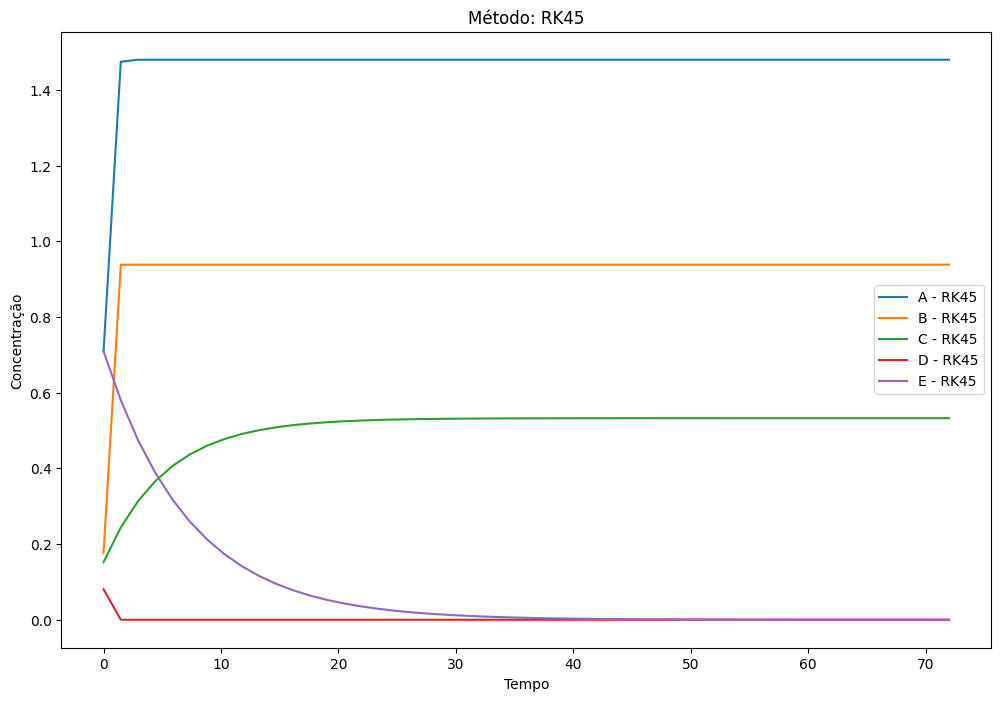

Sigma increased due to no improvement. New sigma: 13036928979810456, 'min': 7.404666657955285, 'max': 8.520578122575147}}}}}}


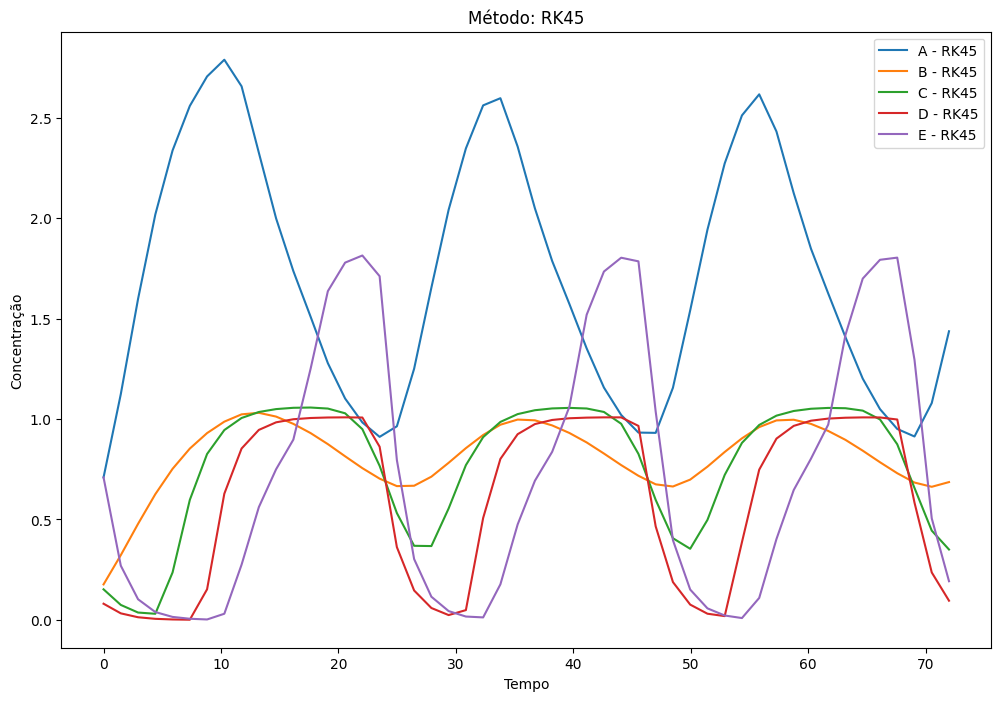

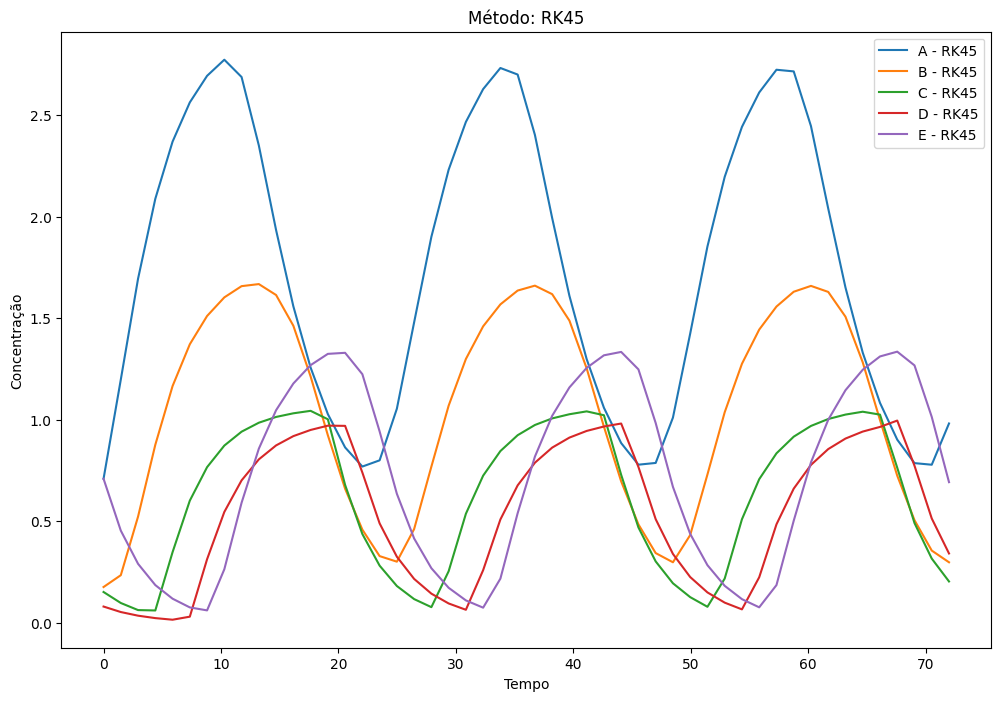

Sigma increased due to no improvement. New sigma: 1 0.006710130966976076, 'min': 2.580053588043997, 'max': 2.6032538610266953}}}


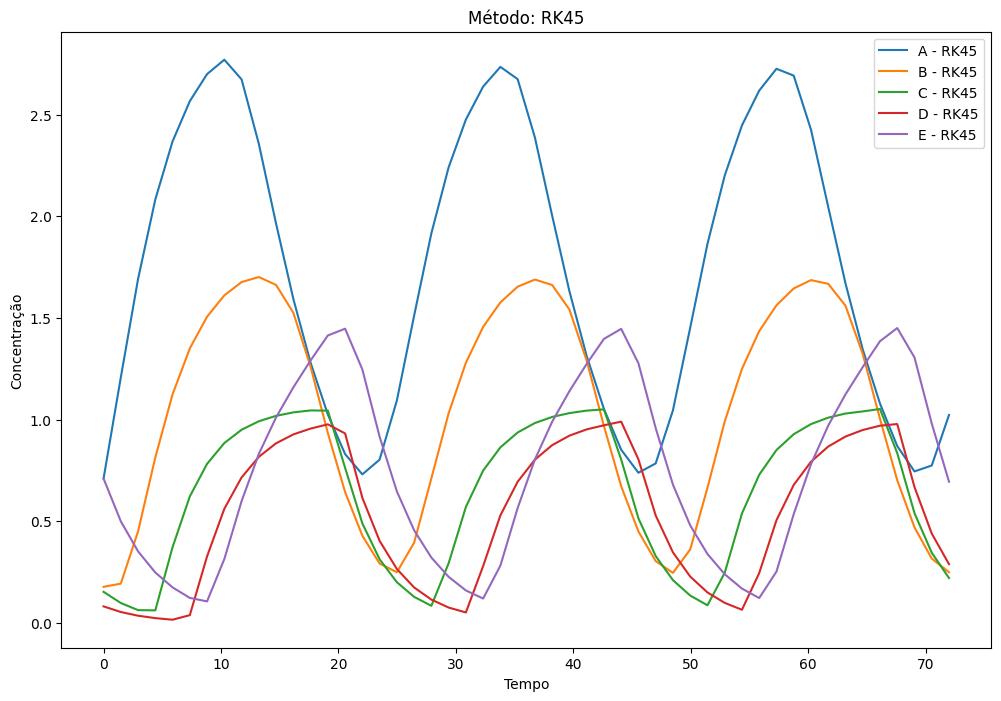

Sigma increased due to no improvement. New sigma: 10.7508900686801335, 'min': 2.485190873558217, 'max': 5.214844043313288}638}}
Sigma increased due to no improvement. New sigma: 1.8868463223186163154, 'min': 2.5233201893636825, 'max': 2.7537490918938325}
Sigma increased due to no improvement. New sigma: 2.982960498717833524, 'min': 2.6388779836560596, 'max': 2.8755309942504157}}
Sigma increased due to no improvement. New sigma: 3.03621395891205865835, 'min': 2.662652663730159, 'max': 2.8525880261085157}


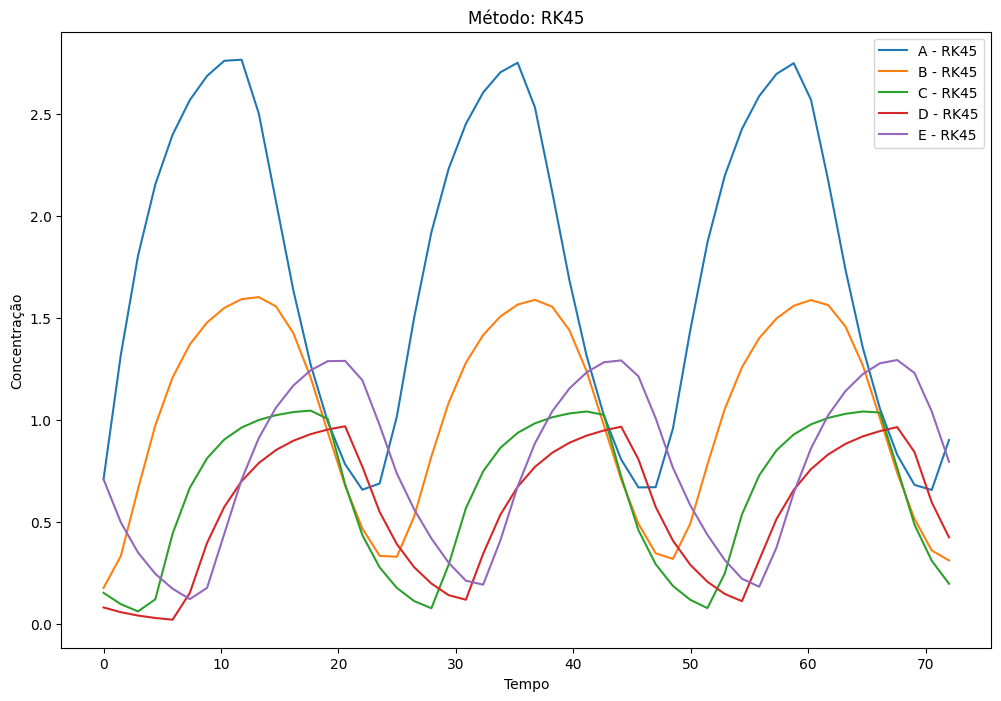

Sigma increased due to no improvement. New sigma: 1 0.0037332705494081005, 'min': 2.2770828140901975, 'max': 2.2905858032490847}
Sigma increased due to no improvement. New sigma: 1.6180409488653644881, 'min': 2.279256750734209, 'max': 2.308872666760167}2}}
Sigma increased due to no improvement. New sigma: 3.2618478355409546986, 'min': 2.2795026283704813, 'max': 2.333331452283065}}}
Sigma increased due to no improvement. New sigma: 6.3789556213717685295, 'min': 2.2850141393603947, 'max': 2.455044039524171}}}


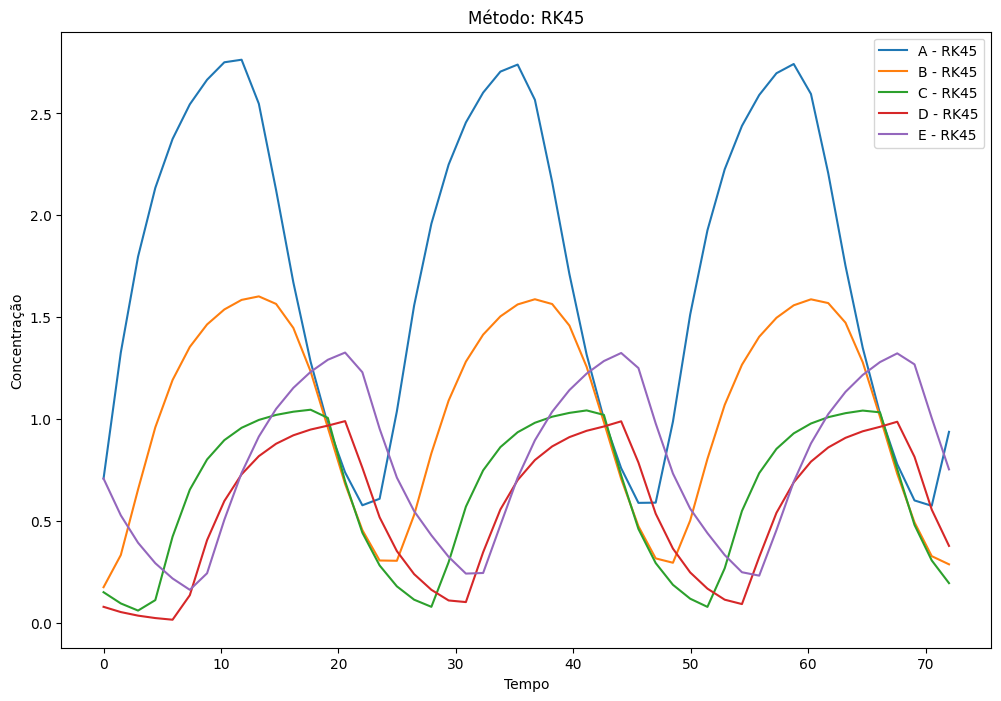

Sigma increased due to no improvement. New sigma: 1.01767561449691211675, 'min': 2.1544273370711515, 'max': 2.193524836354117}3}
Sigma increased due to no improvement. New sigma: 1 0.0016804260632733974, 'min': 2.1485918455765027, 'max': 2.1539650009042743}
Sigma increased due to no improvement. New sigma: 2.10023222275606711476, 'min': 2.1493667974335966, 'max': 2.163138023096201}}}


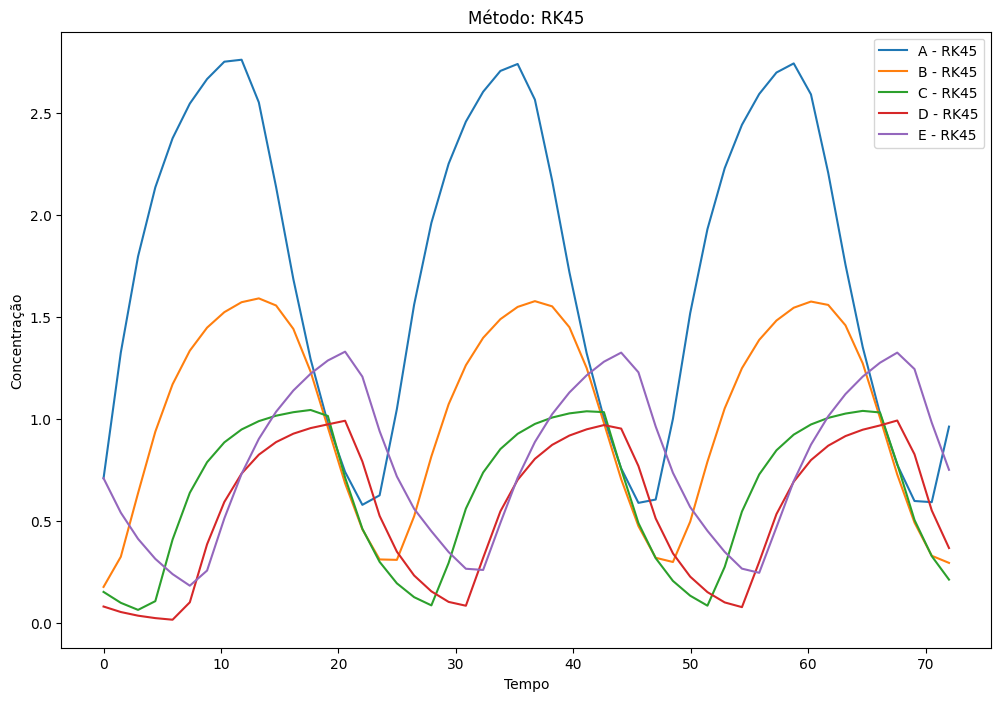

Sigma increased due to no improvement. New sigma: 1.08453227093661746263, 'min': 2.143541023524549, 'max': 2.161760874024756}}}


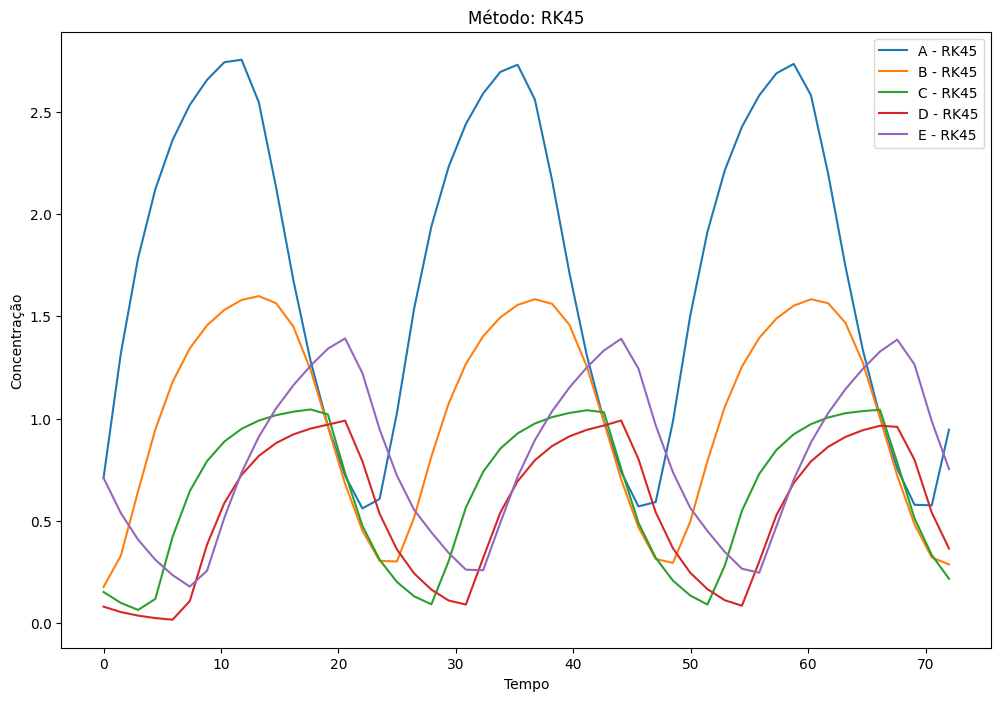

Sigma increased due to no improvement. New sigma: 1 0.002012452883662603, 'min': 2.1111843136999595, 'max': 2.117871127385517}}}
Sigma increased due to no improvement. New sigma: 1.83643073962619597136, 'min': 2.1076598514497795, 'max': 2.126416296114805}5}


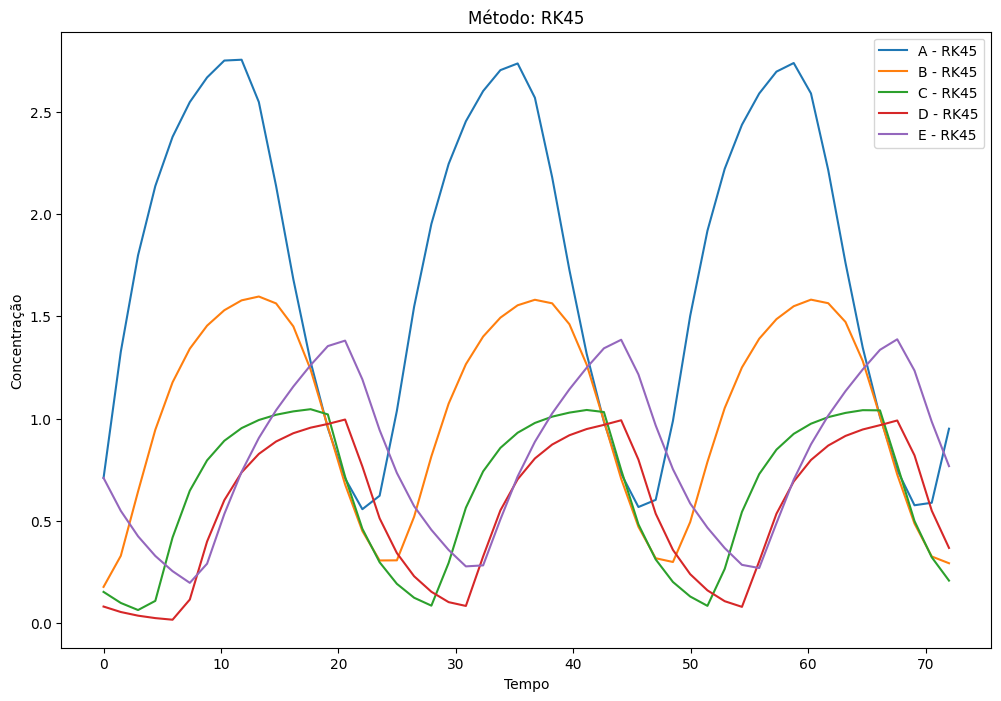

Sigma increased due to no improvement. New sigma: 10.0069604730316767515, 'min': 2.090196135685111, 'max': 2.1162345011249415}}}


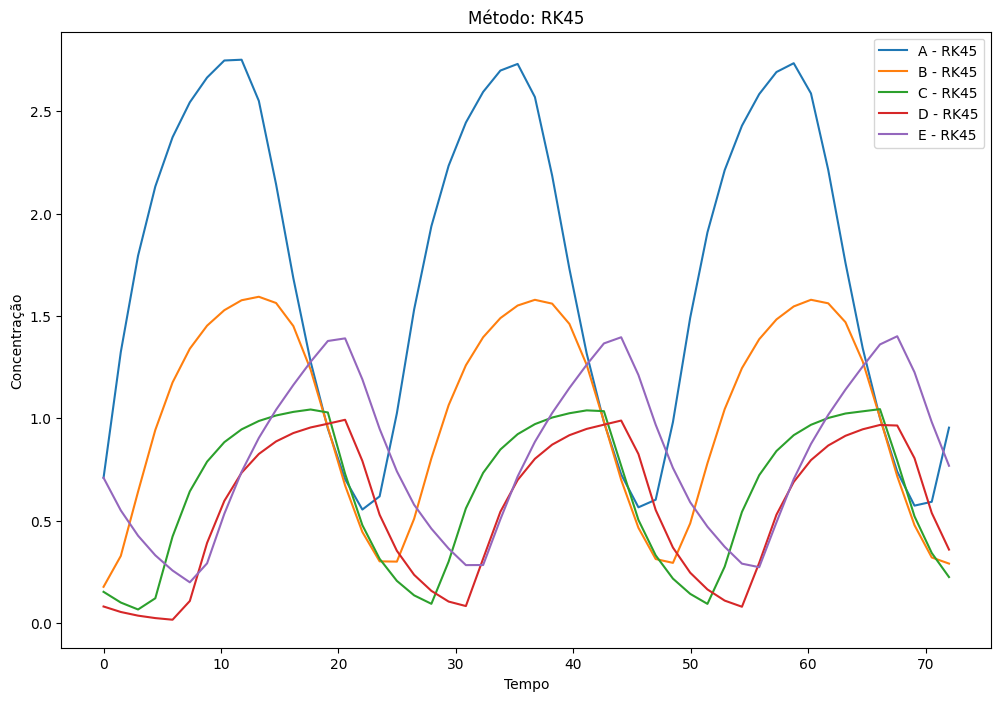

Sigma increased due to no improvement. New sigma: 1.471568295728331813, 'min': 2.0772521281710015, 'max': 2.556548434644123}}}
Sigma increased due to no improvement. New sigma: 4.00921024343074111604, 'min': 2.0773766768275976, 'max': 2.1010854332621434}}
Sigma increased due to no improvement. New sigma: 1.68620298585679977482, 'min': 2.069621313306828, 'max': 2.0976497617581824}}}
Sigma increased due to no improvement. New sigma: 3.5124773991273712774, 'min': 2.068107477412604, 'max': 2.1411456708562833}3}}


In [13]:
GENERATION_LIMIT = 5000
NO_IMPROVEMENT_LIMIT = 50
HARD_SIGMA_INCREASE_FACTOR = 10
TOLERANCE = 1E-4

population = toolbox.generate()
Individual.apply_bounds(population)

best_fitness = None
no_improvement_counter = 0
best_individual = None

for gen in range(GENERATION_LIMIT):
    for i, ind in enumerate(population):
        ind.fitness.values = toolbox.evaluate(ind)

    record = stats.compile(population)

    current_best_fitness = min(ind.fitness.values[0] for ind in population)
    hof.update(population)

    if best_fitness is None or current_best_fitness < best_fitness - TOLERANCE:
        best_fitness = current_best_fitness
        no_improvement_counter = 0
        best_individual = hof[0]
    else:
        no_improvement_counter += 1

    if no_improvement_counter >= (NO_IMPROVEMENT_LIMIT + gen/100):
        
        strategy.sigma = min(max(strategy.sigma*HARD_SIGMA_INCREASE_FACTOR, 1), 15)
        print(f"Sigma increased due to no improvement. New sigma: {strategy.sigma}")
        no_improvement_counter = 0

    toolbox.update(population)

    print(f"Generation {gen}: {record}", end='\r')

    if gen % 500 == 0:
        best_ind = Individual.list_to_ind(best_individual)
        best_ind.plot(comparison=False)

    population = toolbox.generate()
    Individual.apply_bounds(population)

    # population[0][:] = super_ind  # e.g., injecting the best individual into the population


In [17]:
best_ind_obj = Individual.list_to_ind(best_individual)
best_ind_obj.coeffs

{'A': {'E': {'n': val=8.563290282712522,
   'k': val=0.6273731416542248,
   '-': True},
  'tau': val=1.4458782682304037},
 'B': {'A': {'n': val=3.588218714089357,
   'k': val=0.48635647973202434,
   '-': False},
  'tau': val=1.4105717267708777},
 'C': {'B': {'n': val=20.559955681451715,
   'k': val=0.47630238013140913,
   '-': False},
  'tau': val=3.303360948462146},
 'D': {'C': {'n': val=19.52320280161281,
   'k': val=0.5763836806533416,
   '-': False},
  'tau': val=3.6545290758438496},
 'E': {'D': {'n': val=5.079014072634354,
   'k': val=0.2648755510317638,
   '-': False},
  'B': {'n': val=8.145996265460353, 'k': val=0.40134672320217524, '-': False},
  'E': {'n': val=6.017884430673331, 'k': val=1.0812370292335407, '-': False},
  'tau': val=4.028972434806093}}

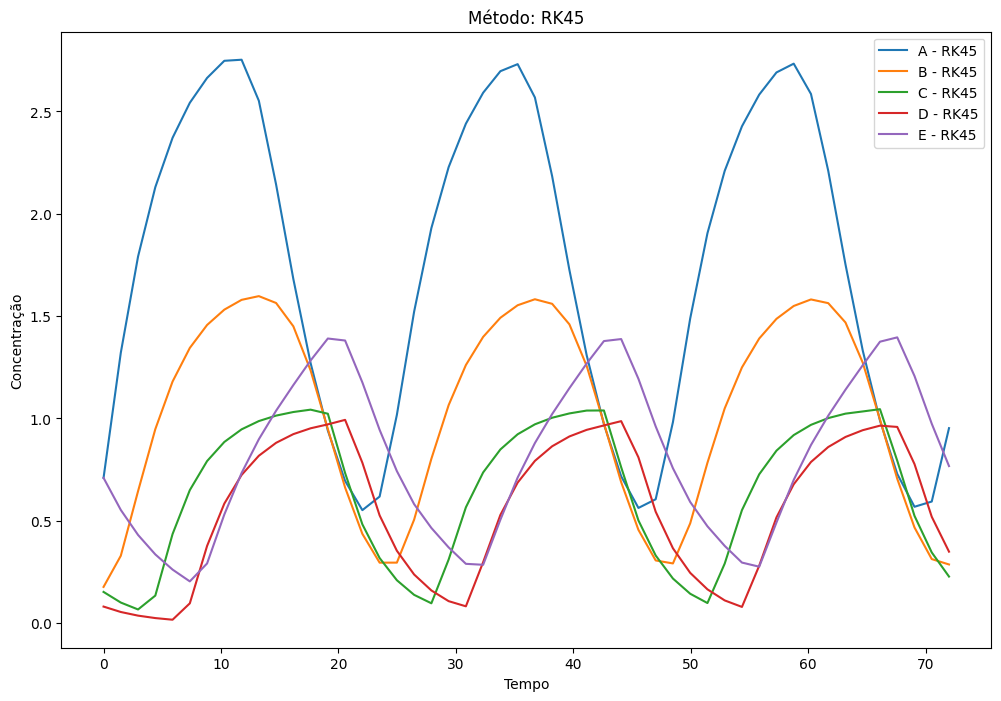

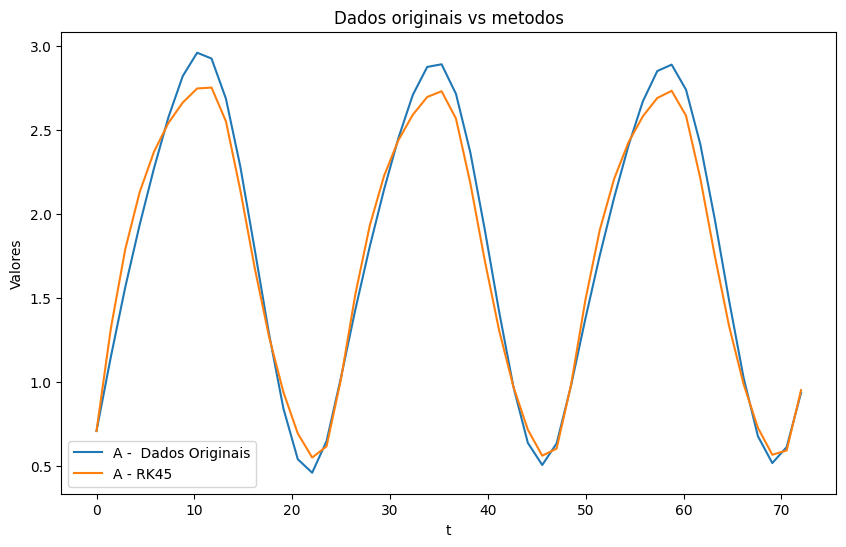

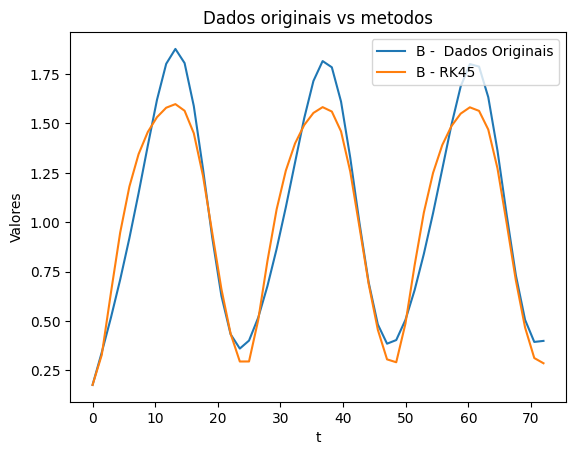

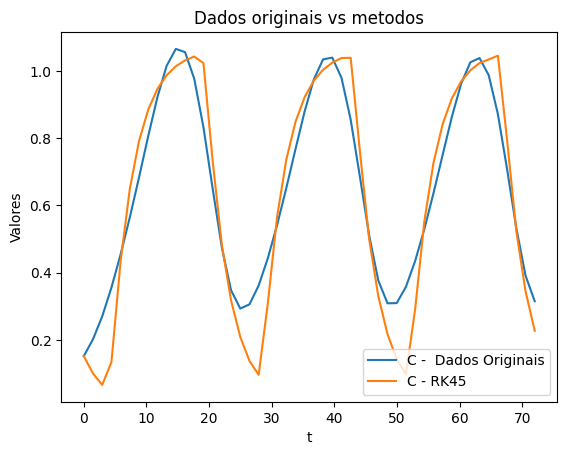

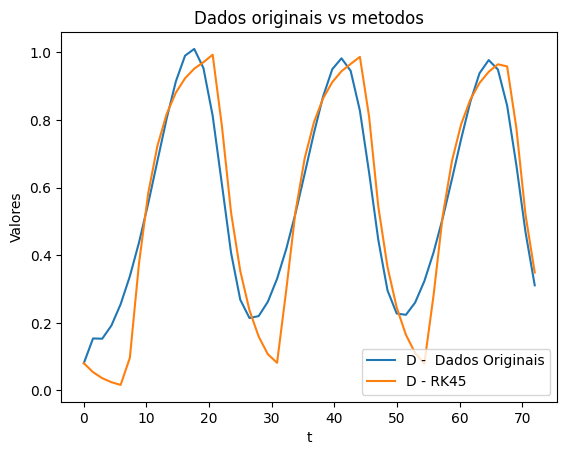

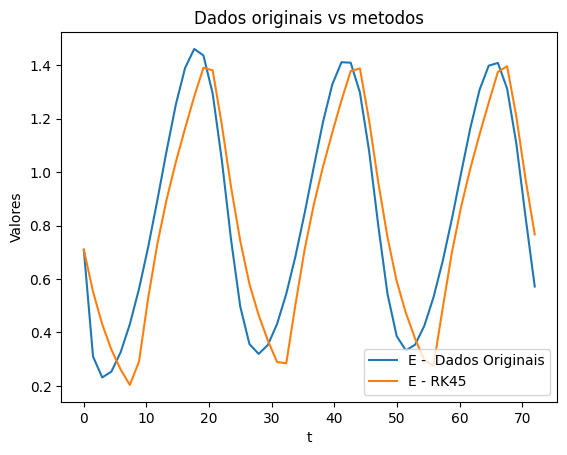

In [20]:
best_ind_obj.plot(comparison=True)

In [ ]:
#encontrado
best_ind_obj.calc_fitness()
best_ind_obj.fitness

2.063458665585002

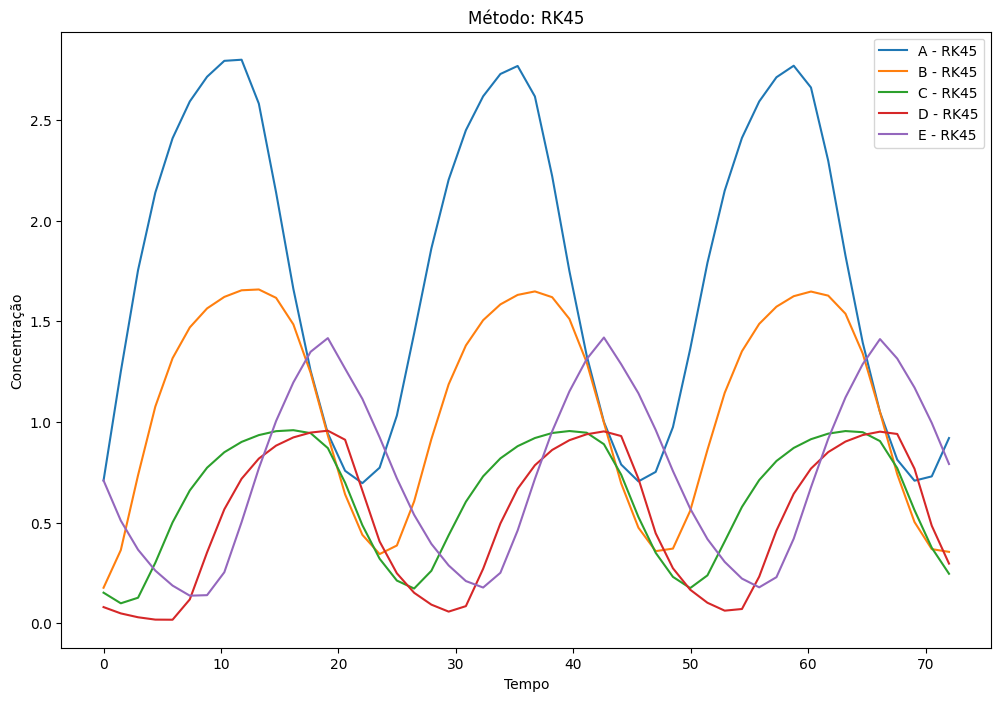

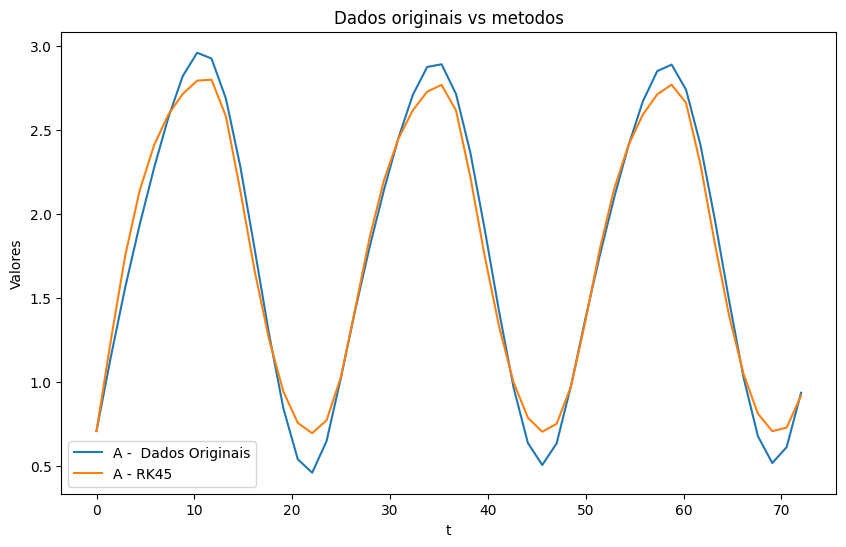

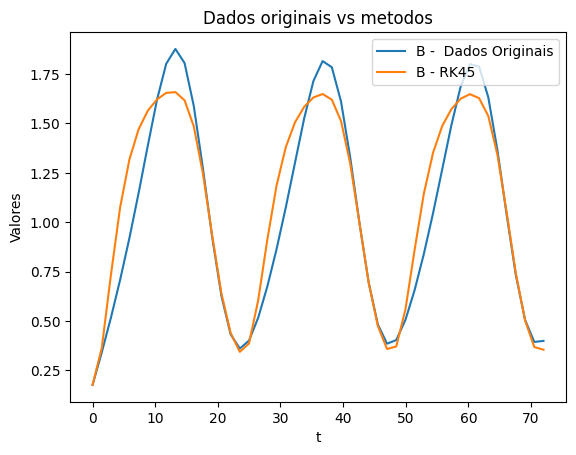

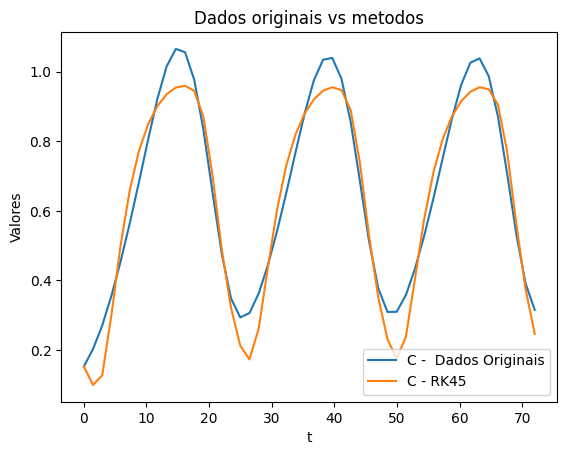

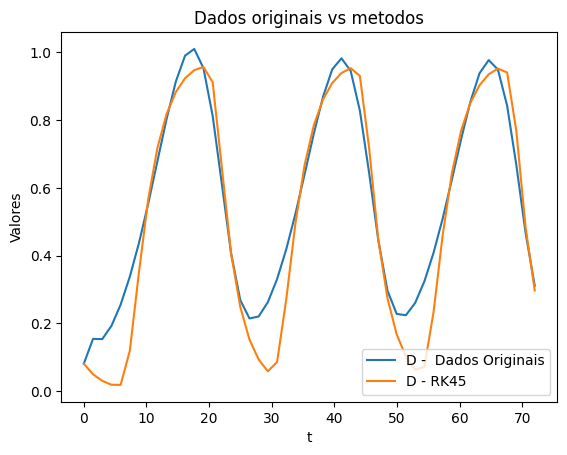

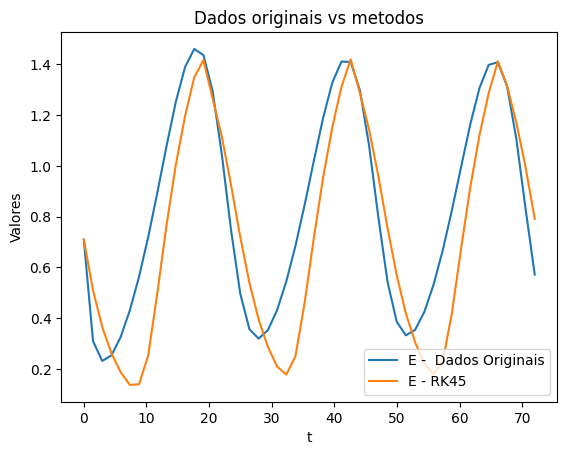

In [24]:
#antigo melhor
best_ind_test.plot(comparison=True)